<a href="https://colab.research.google.com/github/rhdtka21/Intro-To-AI/blob/master/final_project_seokjungwoo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
import os

### Load training datasets

In [106]:
# .p 파일 열고 datasets을 저장
X_train, y_train = pickle.load(open('./train_data.p', 'rb'))
X_test = pickle.load(open('./valid_data.p', 'rb'))

# dataset Type, Shape 출력
print('Type of X_train : {}'.format(type(X_train)))
print('Shape of X_train : {}'.format(X_train.shape))

print('Type of y_train : {}'.format(type(y_train)))
print('Length of y_train : {}'.format(len(y_train)))

print('Type of X_test : {}'.format(type(X_test)))
print('Shape of X_test : {}'.format(X_test.shape))

Type of X_train : <class 'numpy.ndarray'>
Shape of X_train : (1000, 50, 200)
Type of y_train : <class 'list'>
Length of y_train : 1000
Type of X_test : <class 'numpy.ndarray'>
Shape of X_test : (35, 50, 200)


In [0]:
# fastai.vision의 ImageList.from_folder을 사용하기 위해서,
# 데이터 셋들을 폴더에 저장해주는 작업

train_path = 'train_samples/'
test_path = 'test_samples/'
try:
    if not(os.path.isdir(train_path)):
        os.makedirs(os.path.join(train_path))
except OSError as e:
    if e.errno != errno.EEXIST:
        print("Failed to create directory!!!!!")
        raise

try:
    if not(os.path.isdir(test_path)):
        os.makedirs(os.path.join(test_path))
except OSError as e:
    if e.errno != errno.EEXIST:
        print("Failed to create directory!!!!!")
        raise

### Good luck!

In [108]:
# GRAY to RGB 처리 작업

import cv2
#cv2.COLOR_GRAY2RGB

for y_label, X_image in zip(y_train, X_train):
  backtorgb = cv2.cvtColor(np.float32(X_image / 255), cv2.COLOR_GRAY2RGB)
  backtorgb = (backtorgb * 255).astype(np.uint8)
  plt.imsave(train_path + y_label + '.png', backtorgb)

for idx, X_image in enumerate(X_test):
  backtorgb = cv2.cvtColor(np.float32(X_image / 255), cv2.COLOR_GRAY2RGB)
  backtorgb = (backtorgb * 255).astype(np.uint8)
  plt.imsave(test_path + str(idx) + '.png', backtorgb)

print(X_train[0].shape)
print(backtorgb.shape)

(50, 200)
(50, 200, 3)


### Visualize training data

path : train_samples/


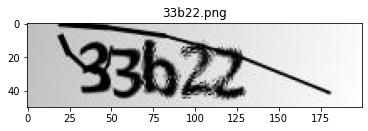

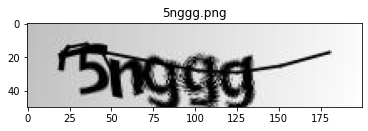

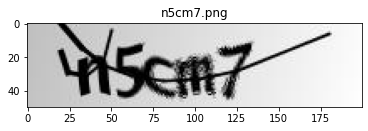

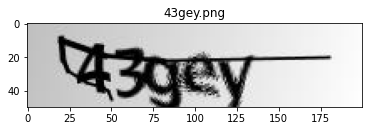

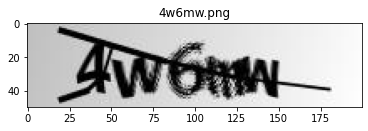

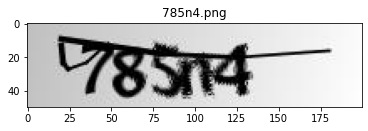

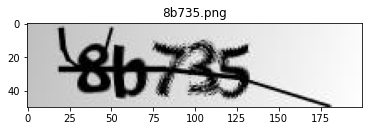

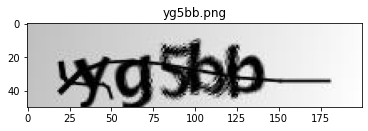

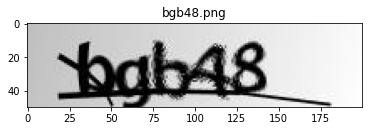

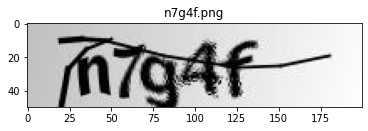

In [109]:
# fastai library 사용해서 학습 모델 생성

from fastai.vision import *

path = train_path

#file명이 곧 label이므로 저장한다.
fileNames = os.listdir(path)
print("path :", path)

# 10개 테스트 출력
for fileName in fileNames[:10]:
    image = cv2.imread(path + fileName, cv2.IMREAD_COLOR)
    plt.imshow(image)
    plt.title(fileName)
    plt.show()

In [0]:
def lr_plotting(learn):
    # learning 모델의 Learning Rate Plot 그리기
    lr_find(learn)
    learn.recorder.plot()

def learning(learn, lr):
    # fastai의 1주기 정책을 활용한 fitting 함수 호출

    # epoch 5 초기 fitting
    learn.fit_one_cycle(5, lr)
    
    # epoch 15 fitting
    learn.unfreeze()
    learn.fit_one_cycle(15, slice(5e-4, lr/5))

def char_from_path(path, position):
    return path.name[position]

def data_from_position(path, position, show = False):
    data = (
          ImageList.from_folder(path)                                     # 경로로 부터 데이터 받음.
          .split_by_rand_pct(0.2)                                         # Split the data between the training and the validation set(train data를 train과 validation으로 또 나눠주는 비율)
          .label_from_func(partial(char_from_path, position=position))    # Label은 파일명으로부터 받아온다. 이때 각 포지션에 맞는 label을 받아옴.
          .transform(get_transforms(do_flip=False))                       # Data augmentation Rotation, Zoom, 등 (글씨이므로 Flip은 하지 않습니다.)
          .databunch()
        )                  
    # 첫자리만 batch 출력해봄. 확인차
    if show:
      print("Data Batch")
      data.show_batch(3)

    return data

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


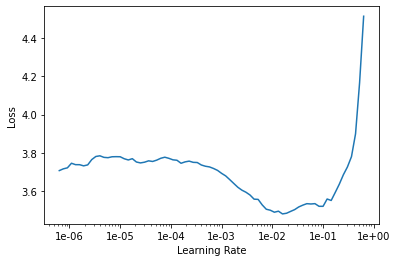

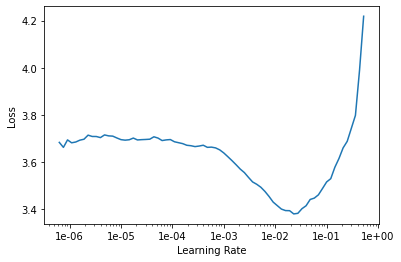

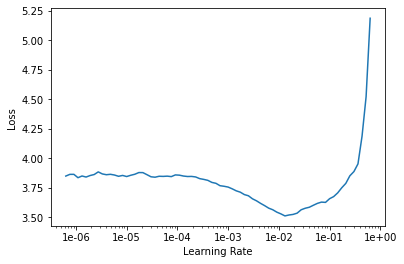

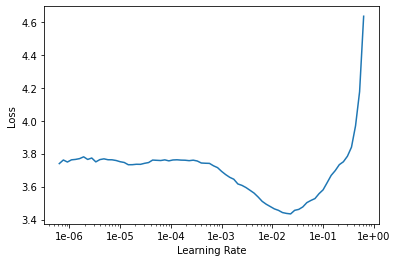

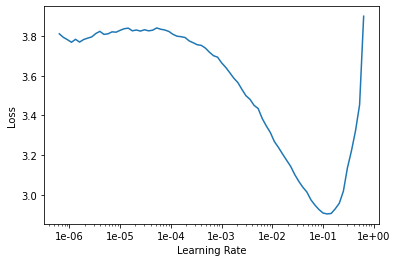

In [111]:
learners = []
# 각 자리별로 따로 라벨링을 해서, 학습을 시작합니다.
# 같은 이미지를 학습해도, 각 자리별로 학습 모델을 만들었기에,
# 박복되는 Convu
for i in range(5):
    # 각 글자수 자리별로 데이터들을 생성한다.
    data = data_from_position(train_path, i)
    
    # CNN 모델 생성, resnet34 사용
    learn = cnn_learner(data, models.resnet34, metrics=accuracy, model_dir='/tmp', ps=0.)

    # Learning Rate별 Loss에 따른 Plotting
    lr_plotting(learn)
   
    learners.append(learn)    

In [112]:
# model을 fit한다.
# 각 모델들은 restnet cnn 모델로 구현되어 있다.
for learn in learners:
    lr = 5e-2
    learning(learn, lr)

epoch,train_loss,valid_loss,accuracy,time
0,4.339974,10.489455,0.080000,00:02
1,4.242916,17.585243,0.030000,00:02
2,3.704657,4.739958,0.155000,00:02
3,3.110233,3.058756,0.320000,00:02
4,2.645678,1.540738,0.440000,00:02


epoch,train_loss,valid_loss,accuracy,time
0,1.572181,1.687275,0.490000,00:02
1,1.429416,3.054461,0.365000,00:02
2,1.252535,6.553048,0.180000,00:02
3,1.129598,7.806771,0.175000,00:02
4,1.013483,1.748585,0.560000,00:02
5,0.899331,0.919513,0.695000,00:02
6,0.775900,1.300968,0.700000,00:02
7,0.679371,0.147848,0.940000,00:02
8,0.586680,0.842710,0.790000,00:02
9,0.496453,0.208680,0.915000,00:02


epoch,train_loss,valid_loss,accuracy,time
0,4.197320,12.009757,0.055000,00:02
1,4.294312,24.952253,0.055000,00:02
2,3.971811,6.264203,0.110000,00:02
3,3.397196,2.935406,0.200000,00:02
4,2.951800,2.067799,0.325000,00:02


epoch,train_loss,valid_loss,accuracy,time
0,1.766003,3.025775,0.220000,00:02
1,1.531462,2.205178,0.385000,00:02
2,1.311151,2.931713,0.405000,00:02
3,1.152809,2.871029,0.465000,00:02
4,1.006859,4.121054,0.195000,00:02
5,0.873721,1.033130,0.630000,00:02
6,0.767068,0.635001,0.850000,00:02
7,0.660351,1.344254,0.600000,00:02
8,0.558981,0.823165,0.795000,00:02
9,0.466953,0.296719,0.905000,00:03


epoch,train_loss,valid_loss,accuracy,time
0,4.423001,12.259146,0.080000,00:02
1,4.348474,23.768927,0.070000,00:02
2,3.955636,9.215054,0.090000,00:02
3,3.428513,3.448514,0.170000,00:02
4,3.012793,2.452391,0.230000,00:02


epoch,train_loss,valid_loss,accuracy,time
0,2.008807,3.266315,0.190000,00:02
1,1.708820,4.554982,0.125000,00:02
2,1.473083,2.097640,0.420000,00:02
3,1.285729,3.745756,0.225000,00:02
4,1.130122,1.581780,0.590000,00:02
5,0.988961,3.316111,0.330000,00:02
6,0.848091,1.247155,0.670000,00:02
7,0.732979,0.333502,0.915000,00:02
8,0.616837,0.283931,0.910000,00:02
9,0.508152,0.265727,0.925000,00:02


epoch,train_loss,valid_loss,accuracy,time
0,4.234380,11.744082,0.070000,00:02
1,4.358774,16.312315,0.030000,00:02
2,3.939201,5.242229,0.100000,00:02
3,3.382619,3.237443,0.165000,00:02
4,2.906106,2.189419,0.295000,00:02


epoch,train_loss,valid_loss,accuracy,time
0,1.762639,2.502512,0.300000,00:03
1,1.524623,2.235490,0.345000,00:02
2,1.316631,6.210166,0.205000,00:02
3,1.179786,12.869411,0.240000,00:02
4,1.063274,3.475430,0.385000,00:02
5,0.941258,2.615793,0.495000,00:02
6,0.794469,0.800847,0.760000,00:02
7,0.663168,1.778859,0.595000,00:02
8,0.553439,0.494539,0.845000,00:02
9,0.454996,0.157158,0.950000,00:02


epoch,train_loss,valid_loss,accuracy,time
0,3.448470,18.346832,0.085000,00:02
1,2.853591,40.504189,0.070000,00:02
2,2.212170,10.869825,0.290000,00:02
3,1.636905,1.020513,0.745000,00:02
4,1.246516,0.296569,0.900000,00:02


epoch,train_loss,valid_loss,accuracy,time
0,0.384649,1.567830,0.690000,00:02
1,0.359159,4.795839,0.360000,00:02
2,0.382742,25.857954,0.120000,00:02
3,0.437902,15.458696,0.290000,00:02
4,0.427447,2.241329,0.590000,00:02
5,0.387376,1.533945,0.785000,00:02
6,0.347450,0.156599,0.940000,00:02
7,0.285771,0.105466,0.950000,00:02
8,0.237017,0.123035,0.975000,00:02
9,0.195800,0.184464,0.920000,00:02


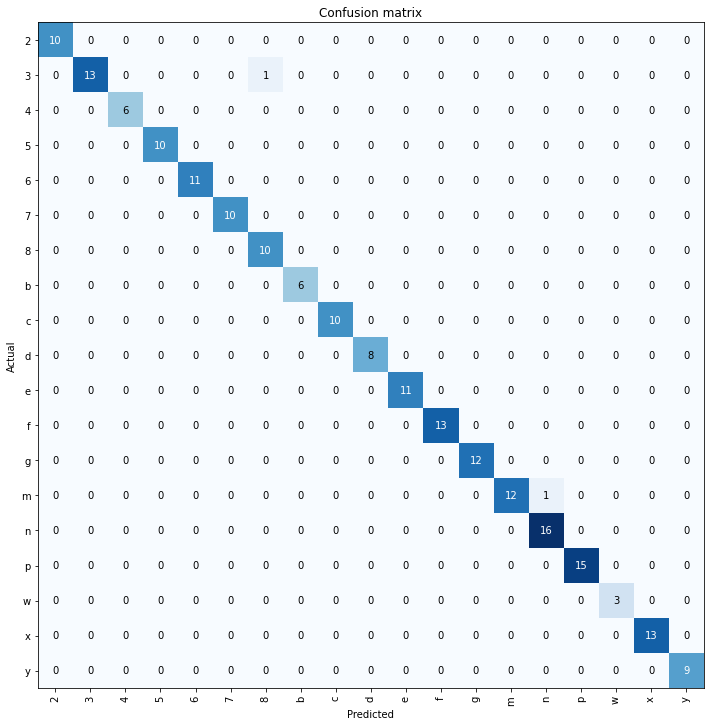

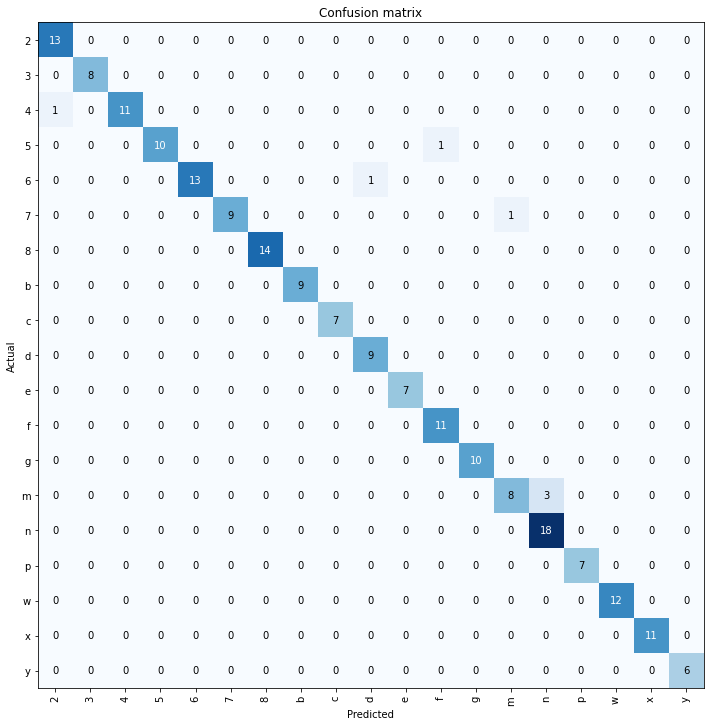

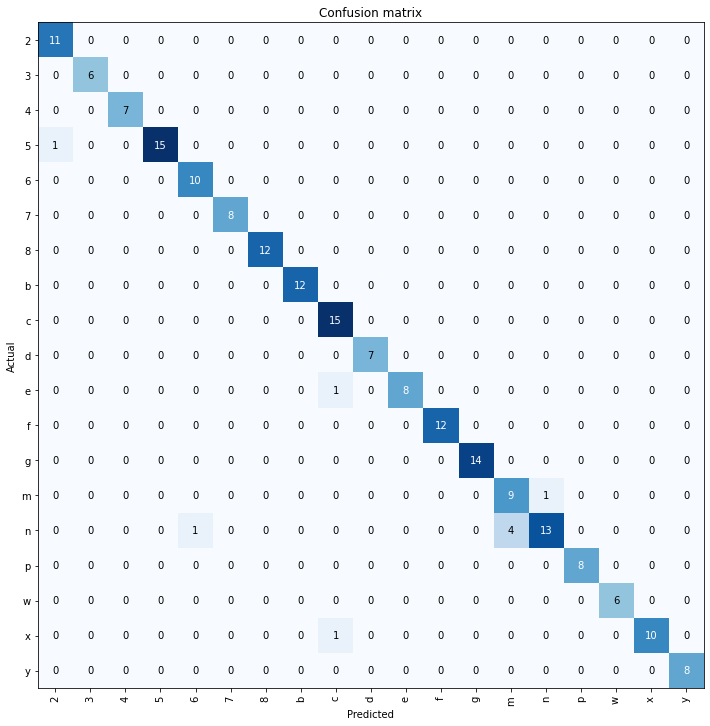

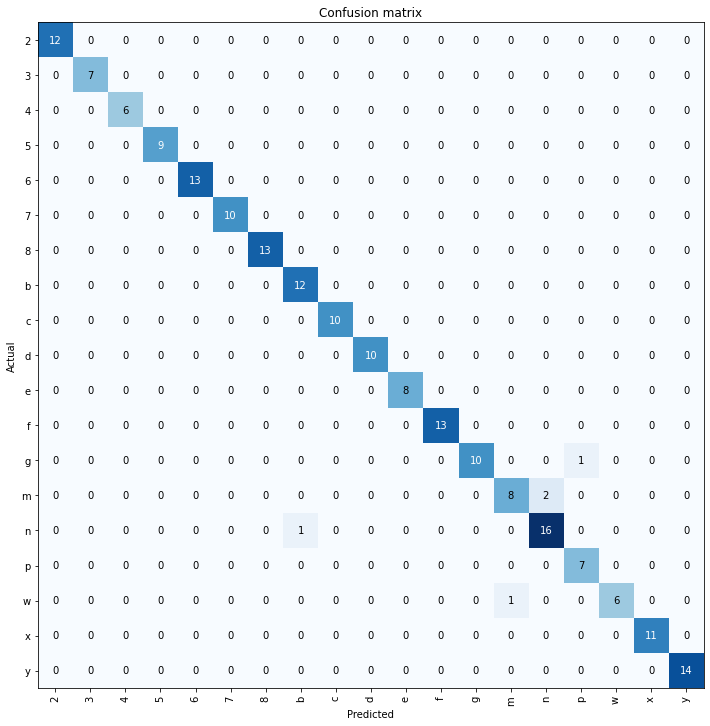

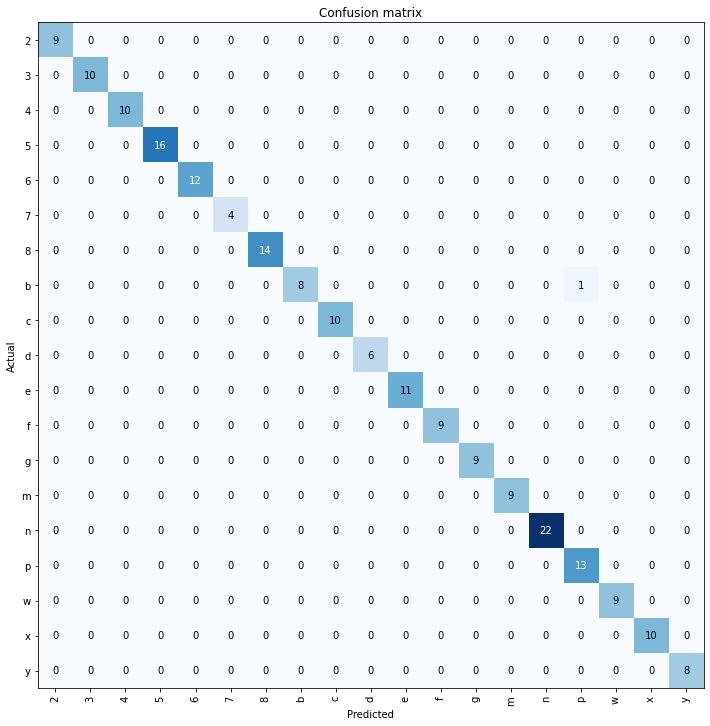

In [113]:
# learn 모델들의 분류결과를 matrix로 표현한다.
# predict와 Actual 데이터의 비교
for learner in learners:
  interp = ClassificationInterpretation.from_learner(learner)
  interp.plot_confusion_matrix(figsize=(10,10))

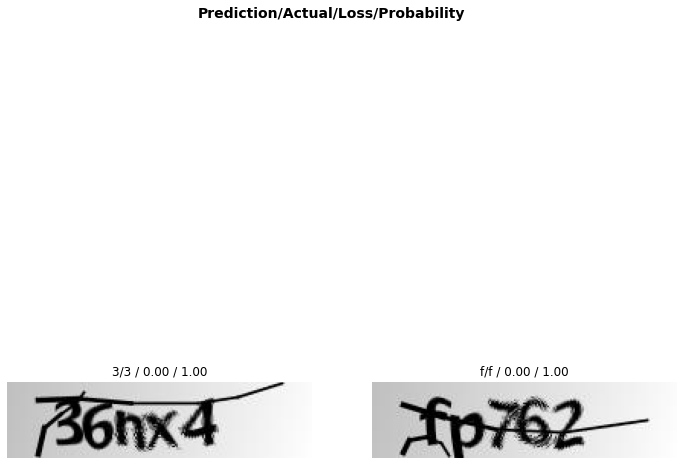

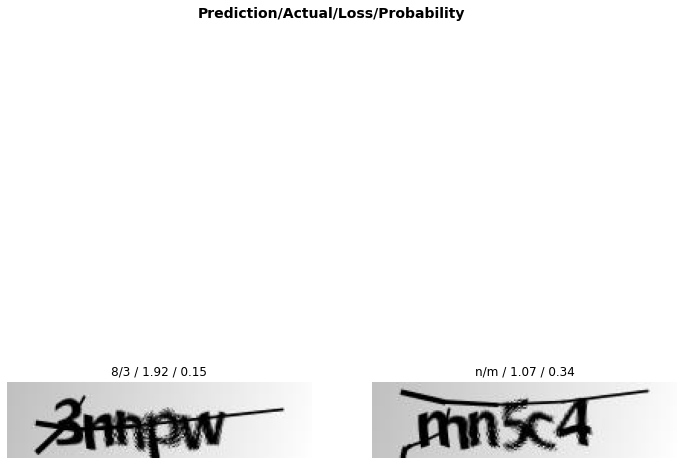

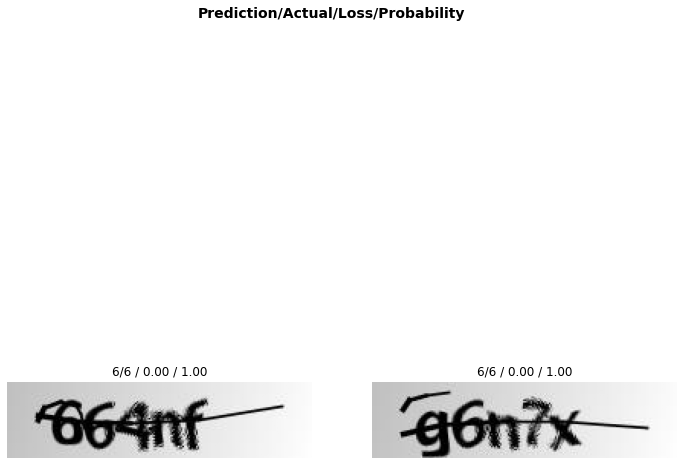

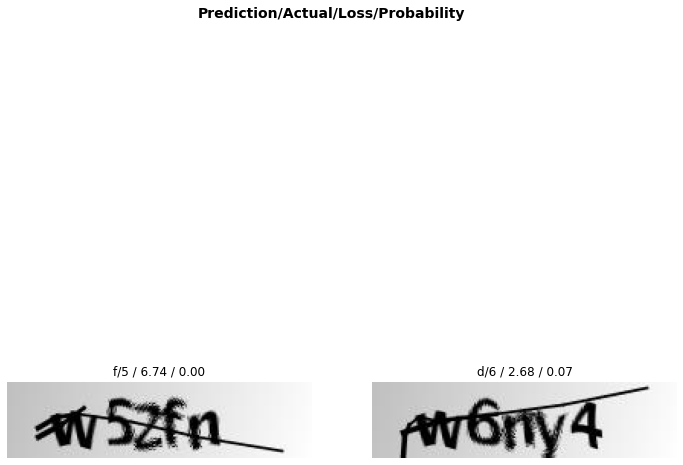

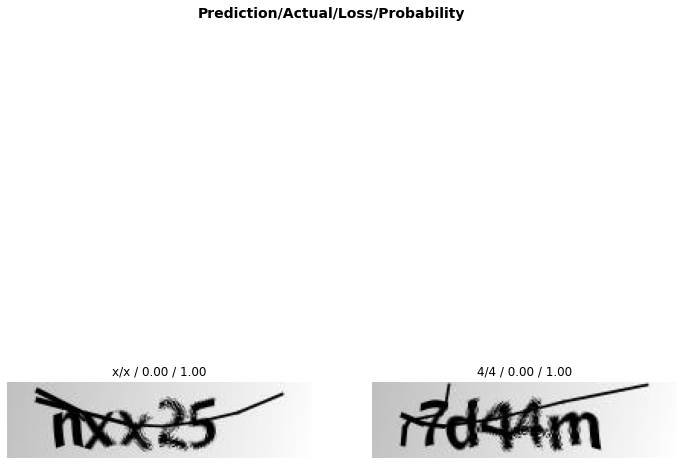

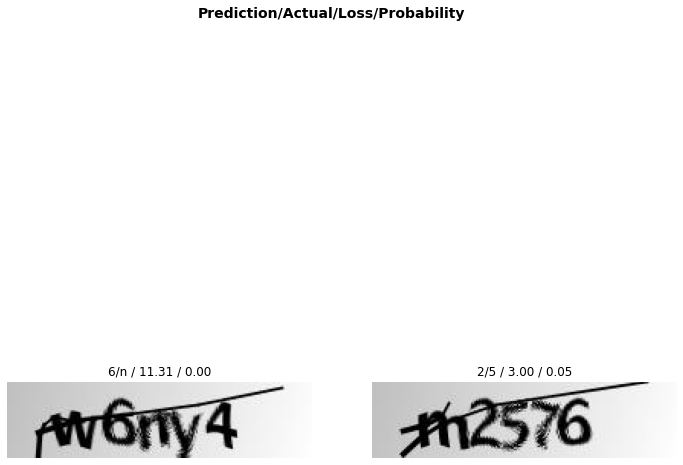

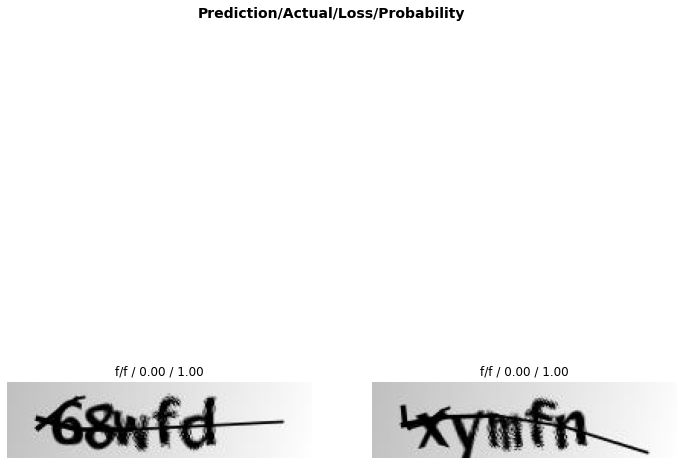

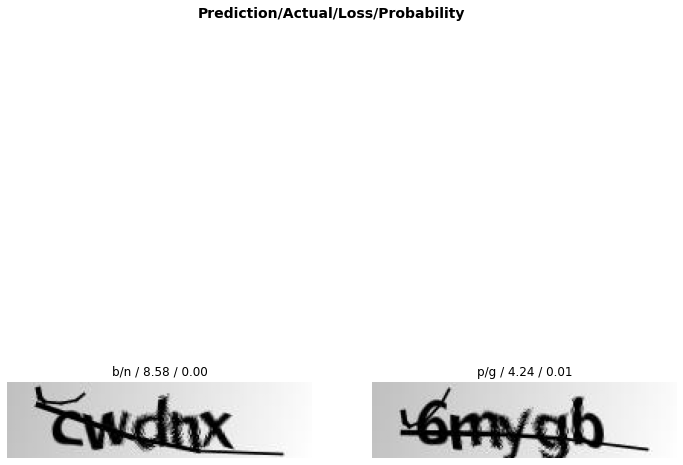

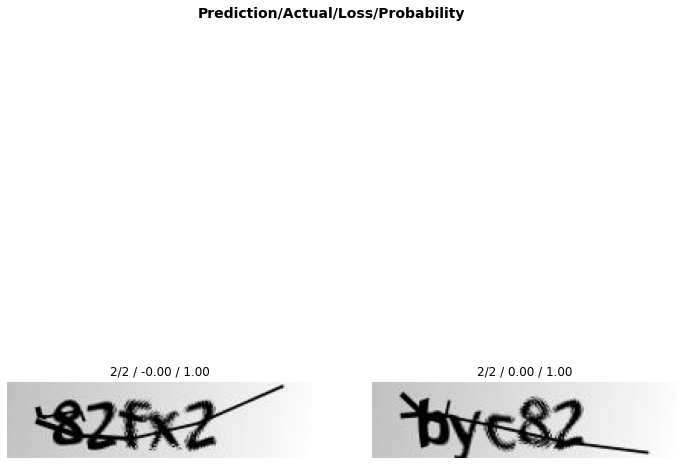

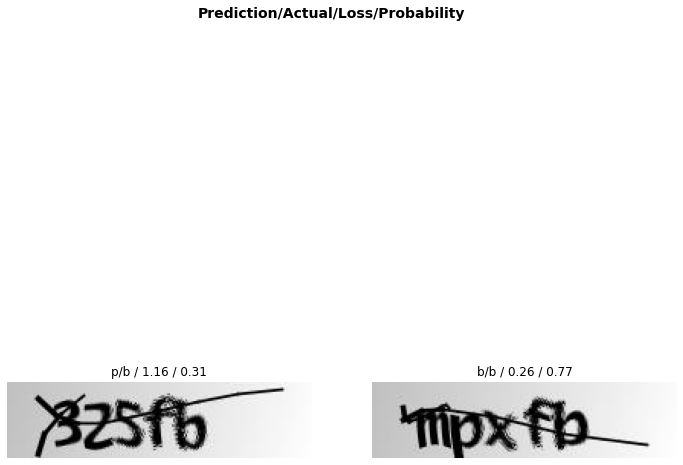

In [114]:
# 상위 예측률 2개와 
# 하위 예측률 2개
figures = []
for learner in learners:
    figures.append(learner.interpret().plot_top_losses(2, heatmap_thresh=1, largest=False, return_fig=True))
    figures.append(learner.interpret().plot_top_losses(2, heatmap_thresh=1, largest=True, return_fig=True))

In [0]:
# 각 이미지를 넣어서 예측값 string을 출력하는 함수

def predict_captcha(img, learners):
    return ''.join([str(learner.predict(img)[0]) for learner in learners])

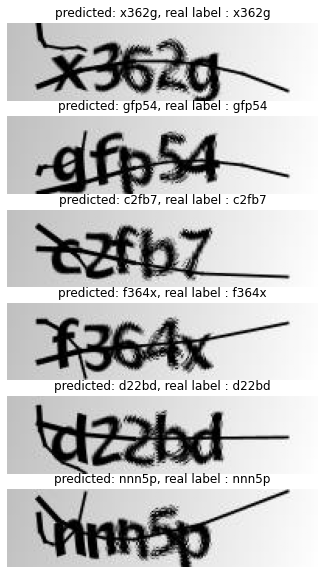

In [116]:
# 학습이 제대로 되었고, 제대로 동작하는지를 확인하기 위해서 
# valid data set을 num개 출력

num = 6
fig, ax = plt.subplots(nrows=num, figsize=(20,10))
img_paths = learners[0].data.valid_ds.items
count = 0
correct = 0

for a, img_path in zip(ax.flatten()[:num], img_paths[:num]):

    lbl = img_path.name[:-4]
    img = open_image(img_path)
    predicted = predict_captcha(img, learners)
    show_image(img, a)
    a.set_title(f'predicted: {predicted}, real label : {lbl}')
    if lbl==predicted: correct +=1
    count += 1

plt.show()

In [117]:
# 전체 valid data set 에 대해서 성능 평가

img_paths = learners[0].data.valid_ds.items
count = 0
correct = 0

for img_path in img_paths:
    lbl = img_path.name[:-4]
    img = open_image(img_path)
    predicted = predict_captcha(img, learners)
    if lbl==predicted: correct +=1
    count += 1
correct/count

0.935

### Fomatting Kaggle submission

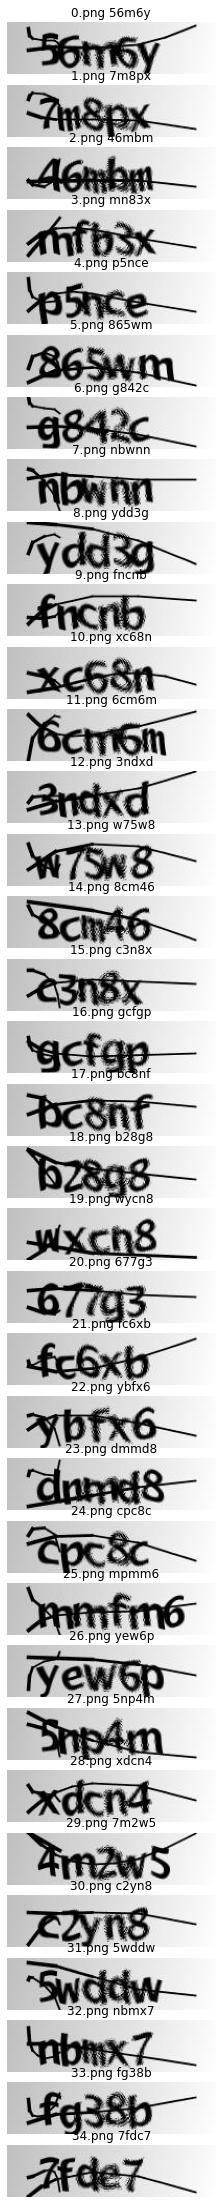

0.8285714285714286
6
[3, 19, 23, 25, 29, 34]


In [118]:
data = (ImageList.from_folder(test_path))                                 # 경로로 부터 데이터 받음.
fileNames = os.listdir(test_path)
test_images = {}
y_test_pred = []
y_test_label = ['56m6y', '7m8px', '46mbm', 'mfb3x', 'p5nce', '865wm', 'g842c', 
                'nbwnn', 'ydd3g', 'fncnb', 'xc68n', '6cm6m', '3ndxd', 'w75w8', 
                '8cm46', 'c3n8x', 'gcfgp', 'bc8nf', 'b28g8', 'wxcn8', '677g3', 
                'fc6xb', 'ybfx6', 'dnmd8', 'cpc8c', 'mmfm6', 'yew6p', '5np4m', 
                'xdcn4', '4m2w5', 'c2yn8', '5wddw', 'nbmx7', 'fg38b', '7fde7']

count = 0
correct = 0
uncorrect = []

fig, ax = plt.subplots(nrows=35, figsize=(250,40))

for idx, fileName in enumerate(fileNames):
    num = int(fileName[:-4])
    test_images[num] = data[idx]

for i in range(35):
    a = ax.flatten()[i]
    show_image(test_images[i], a)
    pred = predict_captcha(test_images[i], learners)
    y_test_pred.append(pred)
    a.set_title(str(i) + ".png " + pred)
    if y_test_label[i] == pred:
        correct +=1
    else:
        uncorrect.append(i)
    count += 1

plt.show()
print(correct/count)
print(count - correct)
print(uncorrect)

In [119]:
import csv

with open('sample_submission.csv', 'w') as csvfile:
    fieldnames = ['Id', 'Category']
    writer = csv.DictWriter(csvfile, fieldnames=fieldnames)

    writer.writeheader()
    for i in range(len(y_test_pred)):
        writer.writerow({'Id': 1+i, 'Category': y_test_pred[i]})
print(y_test_pred)

['56m6y', '7m8px', '46mbm', 'mn83x', 'p5nce', '865wm', 'g842c', 'nbwnn', 'ydd3g', 'fncnb', 'xc68n', '6cm6m', '3ndxd', 'w75w8', '8cm46', 'c3n8x', 'gcfgp', 'bc8nf', 'b28g8', 'wycn8', '677g3', 'fc6xb', 'ybfx6', 'dmmd8', 'cpc8c', 'mpmm6', 'yew6p', '5np4m', 'xdcn4', '7m2w5', 'c2yn8', '5wddw', 'nbmx7', 'fg38b', '7fdc7']


In [120]:
import cv2
sample_path = 'samples/'
fileNames = os.listdir(sample_path)
print(fileNames)
for fileName in fileNames:
    src = cv2.imread(sample_path + fileName, cv2.IMREAD_GRAYSCALE)
    cv2.imwrite(fileName, src)

['33b22.png', 'p5nce.png', '5nggg.png', 'n5cm7.png', '43gey.png', '4w6mw.png', '785n4.png', '8b735.png', 'yg5bb.png', 'bgb48.png', 'n7g4f.png', 'wnmyn.png', 'bp6mw.png', 'bny4w.png', 'xfgxb.png', '36nx4.png', 'd75b5.png', '3bx86.png', 'd7nn3.png', 'b6f2p.png', '8d2nd.png', 'deep5.png', 'fbp2c.png', 'gegw4.png', 'dw8d3.png', 'p8wwf.png', 'fg7mg.png', 'ddcdd.png', 'pdcp4.png', '2ycn8.png', '25m6p.png', '76353.png', 'bmxpe.png', 'xe6eb.png', 'y32yy.png', 'w7e6m.png', 'nn4wx.png', 'g78gn.png', '57b27.png', 'be6np.png', 'pp546.png', 'ffd6p.png', 'x3fwf.png', '32dnn.png', '5mcy7.png', 'd3c7y.png', 'ngn26.png', '3ndxd.png', 'bwmee.png', 'm3b5p.png', '25w53.png', 'f858x.png', 'x4pnp.png', 'pgg3n.png', 'wecfd.png', '8gmc4.png', 'nfd8g.png', '5gcd3.png', 'ny3nn.png', 'pxdwp.png', '2yggg.png', 'x4gg5.png', '5x5nx.png', 'w6yne.png', 'p8ngx.png', '55y2m.png', '4f8yp.png', 'fpw76.png', '7gce6.png', 'ncww7.png', 'bp2d4.png', 'nbcgb.png', 'ewcf5.png', '4egem.png', '5xd2e.png', '5expp.png', 'mmg38.png'

In [121]:
sample_path = 'samples/'
data = (ImageList.from_folder(sample_path))                                 # 경로로 부터 데이터 받음.
print(data)
fileNames = os.listdir(sample_path)
print()

img = data[0]
fileName = fileNames[0]

predicted = predict_captcha(img, learners)
print(fileName, predicted)

ImageList (1070 items)
Image (3, 50, 200),Image (3, 50, 200),Image (3, 50, 200),Image (3, 50, 200),Image (3, 50, 200)
Path: samples

33b22.png 33b22


In [122]:
# 개인적인 검증용 samples
correct = 0
count = 0
sample_path = 'samples/'
data = (ImageList.from_folder(sample_path))                                 # 경로로 부터 데이터 받음.
print(data)
fileNames = os.listdir(sample_path)

print()

for img, fileName in zip(data, fileNames):
    lbl = fileName[:-4]
    predicted = predict_captcha(img, learners)
    if lbl==predicted: correct +=1
    count += 1

print(correct/count)
print(count-correct)

ImageList (1070 items)
Image (3, 50, 200),Image (3, 50, 200),Image (3, 50, 200),Image (3, 50, 200),Image (3, 50, 200)
Path: samples

0.9476635514018692
56
